### Expert Notebook: Spark processing
In this notebook, we will demonstrate some basic elements of the Spark cluster for parallel processing.

In [1]:
import datetime as dt                                     # date and time functions  
import openeo                                             # working with OpenEO later in this notebook
import re                                                 # to parse strings (regular expressions)
import os                                                 # operating system functions
from xml.etree import ElementTree as ET                   # XML parsing
import rasterio                                           # raster files 
import matplotlib.pyplot as mplot                         # plotting functions
from mpl_toolkits.axes_grid1 import make_axes_locatable   # more plotting functions
import seaborn as sns                                     # additional plotting tools
import glob                                               # alternative for os to search for files/directories
import numpy as np                                        # standard Python package
import matplotlib.pyplot as plt                           # standard Python plotting routine
import gdal                                               # gdal package
import requests
from urllib.parse import urljoin
from operator import add
import pyspark

In [2]:
# Routine to calculate the histogram for a given (single band) GeoTiff image file.
def histogram(image_file):
    # Open the image file
    img = gdal.Open(image_file)
    
    if img is None:
        print ('-ERROR- Unable to open image file "%s"' % image_file)
    
    # Open raster band (first band)
    raster = img.GetRasterBand(1)    
    xSize  = img.RasterXSize
    ySize  = img.RasterYSize
    #print(img.GetMetadata())
    
    # Read raster data
    data = raster.ReadAsArray(0, 0, xSize, ySize)
    
    #convert DN --> real NDVI values
    data[data == 255] = np.ma.masked
    data = (data * 0.004) - 0.08 
        
    # Calculate histogram, let's ignore the negative NDVI values
    abs_hist, _ = np.histogram(data, bins=25, range=(0.00, 1.00))
    rel_hist    = (100. * abs_hist) / np.sum(abs_hist)
    
    return abs_hist, rel_hist

First, we query the catalogue for Sentinel-2 10 m NDVI files and have the list printed. For now, this is done using the Python requests library. In the near futute, a Python catalogue client will be made available.

In [3]:
productName = 'urn:eop:VITO:TERRASCOPE_S2_NDVI_V2'
startDate   = dt.date(2018,7,1)
endDate     = dt.date(2018,8,1)
tileId      = '31UES'
bbox        = [4.0, 51.0, 5.0, 52.0]

# get the product list
catalog_base_url = 'https://services.terrascope.be/catalogue/'
headers = {'Accept': 'application/json'}
payload = {
    'collection': productName,
    'start': startDate.strftime('%Y-%m-%d'),
    'end': endDate.strftime('%Y-%m-%d'),
    'bbox': '{},{},{},{}'.format(bbox[0], bbox[1], bbox[2], bbox[3]),
    'accessedFrom': 'MEP'
}
response = requests.get(urljoin(catalog_base_url, 'products'),
                        headers = headers,
                        params = payload)

ndviProducts = []
if response.status_code == requests.codes.ok:
    result = response.json()
    for feature in result['features']:
        ndviProducts.append(feature['properties']['links']['data'][0]['href'][7:])
    print('Found {} products:'.format(len(ndviProducts)))
    print([product.split('/')[8] for product in ndviProducts]) #only print the filename, not the entire path, for brevity's sakeness...
else:
    print(response.status_code)
    print(response.json())

Found 54 products:
['S2A_20180703T105621_31UES_NDVI_V200', 'S2A_20180703T105621_31UET_NDVI_V200', 'S2A_20180707T104021_31UES_NDVI_V200', 'S2A_20180707T104021_31UFS_NDVI_V200', 'S2A_20180707T104021_31UFT_NDVI_V200', 'S2A_20180710T105031_31UES_NDVI_V200', 'S2A_20180710T105031_31UET_NDVI_V200', 'S2A_20180710T105031_31UFS_NDVI_V200', 'S2A_20180710T105031_31UFT_NDVI_V200', 'S2A_20180713T105621_31UES_NDVI_V200', 'S2A_20180713T105621_31UET_NDVI_V200', 'S2A_20180717T104021_31UES_NDVI_V200', 'S2A_20180717T104021_31UFS_NDVI_V200', 'S2A_20180717T104021_31UFT_NDVI_V200', 'S2A_20180720T105031_31UES_NDVI_V200', 'S2A_20180720T105031_31UET_NDVI_V200', 'S2A_20180720T105031_31UFS_NDVI_V200', 'S2A_20180720T105031_31UFT_NDVI_V200', 'S2A_20180723T105621_31UES_NDVI_V200', 'S2A_20180723T105621_31UET_NDVI_V200', 'S2A_20180727T104021_31UES_NDVI_V200', 'S2A_20180727T104021_31UFS_NDVI_V200', 'S2A_20180727T104021_31UFT_NDVI_V200', 'S2A_20180730T105031_31UES_NDVI_V200', 'S2A_20180730T105031_31UET_NDVI_V200', 'S2A_

Let's make a sample histogram for the first product file.

Text(0, 0.5, 'Relative frequency [%]')

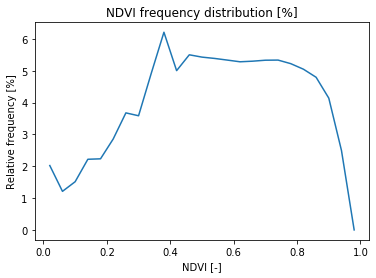

In [4]:
import sys
abs_hist, rel_hist = histogram(ndviProducts[0])
mplot.title('NDVI frequency distribution [%]')

#histogram function was defined to collect the NDVI data in 25 bins within the range [0.00, 1.00]
mplot.plot(np.arange(0, np.size(rel_hist)) * 0.04 + 0.02, rel_hist)
mplot.xlabel('NDVI [-]')
mplot.ylabel('Relative frequency [%]')

Below we calculate the average histogram for all the NDVI files in the list. For this we need to sum the absolute histogram values of the respective bins and calculate the relative histogram from the aggregated absolute frequencies.

CPU times: user 2min 6s, sys: 44.7 s, total: 2min 51s
Wall time: 2min 51s


Text(0, 0.5, 'Cumulative frequency [%]')

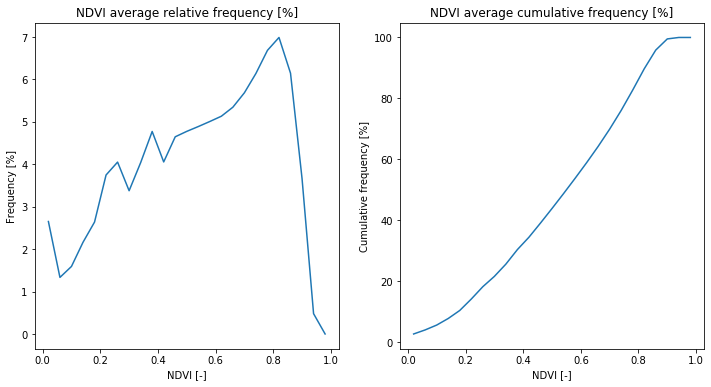

In [5]:
%%time

cum_hist = np.arange(np.size(abs_hist)) * 0.

for f in ndviProducts:
    abs_hist, rel_hist = histogram(f)
    cum_hist += abs_hist

#calculate the relative histogram from the accumulated bins
av_hist     = 100. * (cum_hist / np.sum(cum_hist))
cum_av_hist = np.cumsum(av_hist)

mplot.figure(figsize=(12,6))
mplot.subplot(121)
mplot.title('NDVI average relative frequency [%]')
mplot.plot(np.arange(0, np.size(cum_hist)) * 0.04 + 0.02, av_hist)
mplot.xlabel('NDVI [-]')
mplot.ylabel('Frequency [%]')

mplot.subplot(122)
mplot.title('NDVI average cumulative frequency [%]')
mplot.plot(np.arange(0, np.size(cum_hist)) * 0.04 + 0.02, cum_av_hist)
mplot.xlabel('NDVI [-]')
mplot.ylabel('Cumulative frequency [%]')


So, this took quite some time to complete. Let's see if we can get the job done sooner when we use the SPARK cluster and do parallel processing. Of course, this is not really a representative example and keep in mind that you will gain processing time increasingly with an increasing amount of files to be processed. 

To work on the processing cluster, we need to specify the resources we want:

* <b>spark.yarn.executor.memoryOverhead</b>: memory available for Python
* <b>spark.executor.cores</b>: Number of cores per executor. Usually our tasks are single threaded, so 1 is a good default.
* <b>spark.executor.memory</b>: memory to assign per executor. Memory available for Spark and Java, this can be small when most of your processing is in Python.

We set up the SparkConf with these parameters and create a SparkContext ```sc```, which will be our access point to the cluster.
The virtual memory used is set at 2 GB to optimally exploit the parallel processing capacity.

In [6]:
os.environ['PYSPARK_PYTHON']='/usr/bin/python3.6'

# Setup the Spark cluster
print( 'Configuring' ) 
conf = pyspark.SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', '2g')
print( 'Memory overhead' )
conf.set('spark.executor.memory', '2g')
print( 'Memory 2 GB' )
print( 'Configuring - this may take some time' )
%time sc = pyspark.SparkContext.getOrCreate(conf=conf)

Configuring
Memory overhead
Memory 2 GB
Configuring - this may take some time
CPU times: user 36.2 ms, sys: 31.5 ms, total: 67.7 ms
Wall time: 12 s


<div class="alert alert-block alert-warning">
Please pay attention to the second argument in this method call:
 sc.parallelize(ndviProducts,len(ndviProducts))
It specifies the number of 'partitions' that Spark has to use. Partitions can be processed in parallel, so if the number is too low, your job will take a long time to run.
In general, if the work per file is more than one second, it is safe to use as many partitions as there are files.
</div>

In [7]:
%%time

def runInSpark():
    filesRDD = sc.parallelize(ndviProducts,len(ndviProducts))

    # Apply the 'histogram' function to each filename using 'map'
    hists = filesRDD.map(histogram)

    #Combine distributed histograms into a single result
    total = list(hists.reduce(lambda h, i: map(add, h, i)))
    return total
%timeit -n1 runInSpark()

14.6 s ± 2.92 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU times: user 137 ms, sys: 39 ms, total: 176 ms
Wall time: 1min 42s


In [8]:
total = runInSpark()

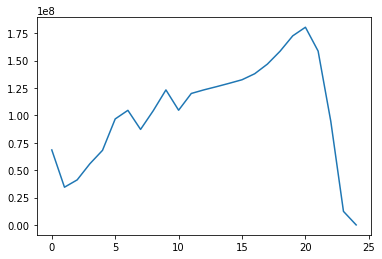

In [9]:
plt.plot(total[0])

In [11]:
# are the results the same?
difference = av_hist - (100. * total[0] / np.sum(total[0]))

for i in range(len(av_hist)):
    print(np.round(av_hist[i], 4), np.round(100. * total[0][i]/np.sum(total[0]), 4), np.round(difference[i],4))

if sum(np.abs(difference)) <= 0.0001:
    print("Yes, they are the same!")
else:
    print("They're not the same? How come?")

2.6507 2.6507 -0.0
1.3334 1.3334 0.0
1.5916 1.5916 0.0
2.1607 2.1607 -0.0
2.6373 2.6373 0.0
3.7471 3.7471 0.0
4.0511 4.0511 0.0
3.3766 3.3766 0.0
4.0379 4.0379 0.0
4.773 4.773 0.0
4.0551 4.0551 0.0
4.6476 4.6476 0.0
4.7755 4.7755 0.0
4.8891 4.8891 0.0
5.0081 5.0081 0.0
5.1325 5.1325 0.0
5.3451 5.3451 0.0
5.6853 5.6853 0.0
6.1411 6.1411 0.0
6.685 6.685 0.0
6.9889 6.9889 0.0
6.1466 6.1466 0.0
3.6623 3.6623 0.0
0.4784 0.4784 0.0
0.0 0.0 0.0
Yes, they are the same!


Stop the SparkContext.

In [12]:
sc.stop()